# Task 2.1 Vanilla GAN

In [1]:
import torch
import torch.nn.functional as f
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Load Mnist data

In [2]:
batch_size = 64

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

image_size =28
Z_dim = 100
X_dim = image_size*image_size
# y_dim = train_labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4606697.91it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 66745.66it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1271026.93it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4155874.51it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Initiate weight Xavier

In [9]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

# Generator

In [10]:
Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z):
    h = f.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = f.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

# Discriminator

In [11]:
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X):
    h = f.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = f.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y


G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

In [ ]:
for i in params:
  print(i.shape)

torch.Size([128])

# Train

In [12]:
def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)


# BCE loss function

In [ ]:
loss_function = nn.BCELoss()

In [ ]:
#num_epochs = 100000
num_epochs = 50

D_avg_losses = []
G_avg_losses = []

def train_GAN(train_loader, loss_function, G, D, num_epochs):
  for epoch in range(num_epochs):
    D_losses = 0
    G_losses = 0

    # minibatch training
    for i, (images, _) in enumerate(train_loader):
      mini_batch = images.size()[0]

      ones_label = Variable(torch.ones(mini_batch, 1))
      zeros_label = Variable(torch.zeros(mini_batch, 1))
      # Sample data
      z = Variable(torch.randn(mini_batch, Z_dim))
      X = images.view(-1, X_dim)
      X = Variable(X)

      # Dicriminator forward-loss-backward-update
      G_sample = G(z)
      D_real = D(X)
      D_fake = D(G_sample)

      D_loss_real = loss_function(D_real, ones_label)
      D_loss_fake = loss_function(D_fake, zeros_label)
      D_loss = D_loss_real + D_loss_fake

      D_loss.backward()
      D_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # Generator forward-loss-backward-update
      z = Variable(torch.randn(mini_batch, Z_dim))
      G_sample = G(z)
      D_fake = D(G_sample)

      G_loss = loss_function(D_fake, ones_label)

      G_loss.backward()
      G_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # loss values
      D_losses += D_loss.data.numpy()
      G_losses += G_loss.data.numpy()

    D_avg_loss = D_losses/mini_batch
    G_avg_loss = G_losses/mini_batch

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Print and plot every now and then
    if epoch % 1 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))

train_GAN(train_loader, loss_function, G, D, 50)

Iter-0; D_loss: 0.0022551966831088066; G_loss: 9.535200119018555
Iter-1; D_loss: 0.01068241335451603; G_loss: 7.609567165374756
Iter-2; D_loss: 0.02064671739935875; G_loss: 6.866867542266846
Iter-3; D_loss: 0.04155722260475159; G_loss: 6.957976341247559
Iter-4; D_loss: 0.22988960146903992; G_loss: 4.75051736831665
Iter-5; D_loss: 0.44779303669929504; G_loss: 4.851503372192383
Iter-6; D_loss: 0.46968787908554077; G_loss: 3.985485792160034
Iter-7; D_loss: 0.42002564668655396; G_loss: 3.8311736583709717
Iter-8; D_loss: 0.46852296590805054; G_loss: 3.6562633514404297
Iter-9; D_loss: 0.36956560611724854; G_loss: 3.7300240993499756
Iter-10; D_loss: 0.767409086227417; G_loss: 2.505608081817627
Iter-11; D_loss: 0.5135930776596069; G_loss: 2.911527156829834
Iter-12; D_loss: 0.5063055157661438; G_loss: 1.7468600273132324
Iter-13; D_loss: 0.8066165447235107; G_loss: 1.891127347946167
Iter-14; D_loss: 1.0716533660888672; G_loss: 2.3769547939300537
Iter-15; D_loss: 1.178372859954834; G_loss: 1.8669

# Plot result

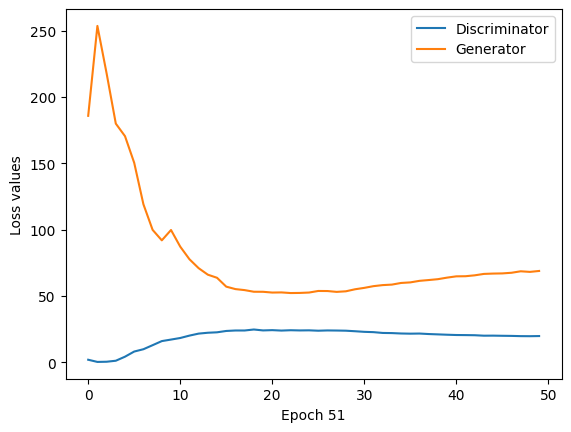

In [ ]:
def plot_loss(d_losses, g_losses, num_epoch):
    fig, ax = plt.subplots()
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

plot_loss(D_avg_losses, G_avg_losses, num_epochs)

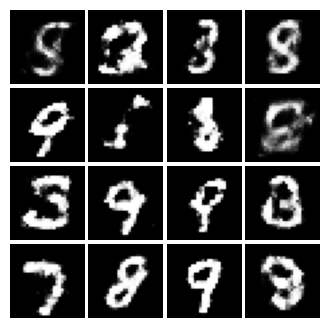

In [ ]:
z = Variable(torch.randn(32, Z_dim))
samples = G(z).data.numpy()[:16]

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
  ax = plt.subplot(gs[i])
  plt.axis('off')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_aspect('equal')
  plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

# Paper described loss

In [ ]:
D_loss = -torch.mean(torch.log(D_real) + torch.log(1. - D_fake))
G_loss = -torch.mean(torch.log(D_fake))

In [14]:
num_epochs = 50

D_avg_losses = []
G_avg_losses = []

def train_GAN_1(train_loader, G, D, num_epochs):
  for epoch in range(num_epochs):
    D_losses = 0
    G_losses = 0

    # minibatch training
    for i, (images, _) in enumerate(train_loader):
      mini_batch = images.size()[0]

      ones_label = Variable(torch.ones(mini_batch, 1))
      zeros_label = Variable(torch.zeros(mini_batch, 1))
      # Sample data
      z = Variable(torch.randn(mini_batch, Z_dim))
      X = images.view(-1, X_dim)
      X = Variable(X)

      # Dicriminator forward-loss-backward-update
      G_sample = G(z)
      D_real = D(X)
      D_fake = D(G_sample)

      D_loss = -torch.mean(torch.log(D_real) + torch.log(1. - D_fake))

      D_loss.backward()
      D_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # Generator forward-loss-backward-update
      z = Variable(torch.randn(mini_batch, Z_dim))
      G_sample = G(z)
      D_fake = D(G_sample)

      G_loss = torch.mean(torch.log(1. - D_fake))

      G_loss.backward()
      G_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # loss values
      D_losses += D_loss.data.numpy()
      G_losses += G_loss.data.numpy()

    D_avg_loss = D_losses/mini_batch
    G_avg_loss = G_losses/mini_batch

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Print and plot every now and then
    if epoch % 1 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))

train_GAN_1(train_loader, G, D, 50)

Iter-0; D_loss: 0.0001500595681136474; G_loss: -4.362181789474562e-05
Iter-1; D_loss: 0.0005825611879117787; G_loss: -8.063637324084993e-06
Iter-2; D_loss: 0.00048646138748154044; G_loss: -7.443784852512181e-05
Iter-3; D_loss: 0.01114481408149004; G_loss: -0.0011913279304280877
Iter-4; D_loss: 0.00027024035807698965; G_loss: -0.0001844810030888766
Iter-5; D_loss: 9.78668776951963e-06; G_loss: -2.3854787286836654e-05
Iter-6; D_loss: 8.348707524419297e-06; G_loss: -8.505687219440006e-06
Iter-7; D_loss: 0.013708237558603287; G_loss: -0.0007166072609834373
Iter-8; D_loss: 0.0030340533703565598; G_loss: -0.00023381956270895898
Iter-9; D_loss: 0.0005290025728754699; G_loss: -0.0001260661520063877
Iter-10; D_loss: 0.0011647756909951568; G_loss: -0.0037924773059785366
Iter-11; D_loss: 0.0222419872879982; G_loss: -0.0026702487375587225
Iter-12; D_loss: 0.022119030356407166; G_loss: -0.0736926719546318
Iter-13; D_loss: 0.16271856427192688; G_loss: -0.09639881551265717
Iter-14; D_loss: 0.09150975

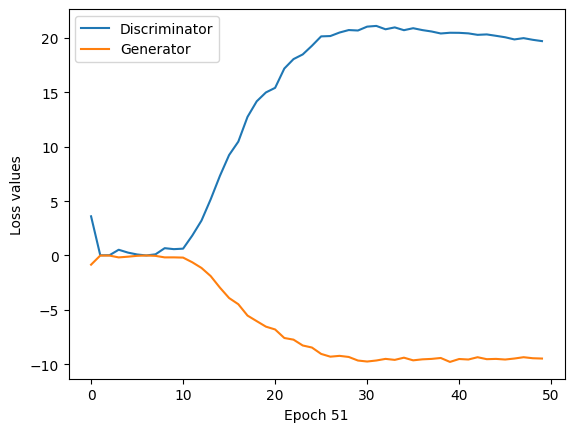

In [15]:
def plot_loss(d_losses, g_losses, num_epoch):
    fig, ax = plt.subplots()
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

plot_loss(D_avg_losses, G_avg_losses, num_epochs)

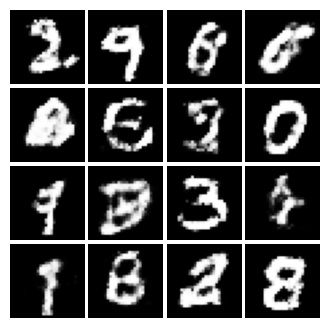

In [16]:
z = Variable(torch.randn(32, Z_dim))
samples = G(z).data.numpy()[:16]

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
  ax = plt.subplot(gs[i])
  plt.axis('off')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_aspect('equal')
  plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

# Loss function compare
The original paper algrithm G_loss is to minimizing tf.reduce_mean(1 - tf.log(D_fake)), this encourages the generator to produce data that the discriminator will classify as real. However, this can cause issues when D_fake is close to zero, as the gradient can vanish, making it hard for the generator to learn. By maximizing tf.reduce_mean(tf.log(D_fake)), the generator receives more useful gradients, especially at the start of training, which can lead to a more stable and efficient learning process.

# Task 2.3 CGAN

In [ ]:
y_dim = 10

In [ ]:
Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

def G_c(z, c):

    inputs = torch.cat([z, c], 1)

    h = f.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = f.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

In [ ]:
Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)

def D_c(X, c):
    inputs = torch.cat([X, c], 1)
    h = f.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1))
    y = f.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y

In [ ]:
to_onehot = nn.Embedding(10, 10)

def train_CGAN(train_loader, loss_function, G_c, D_c, num_epochs):

  for epoch in range(num_epochs):
    D_losses = 0
    G_losses = 0

    # minibatch training
    for i, (images, c) in enumerate(train_loader):
      mini_batch = images.size()[0]

      ones_label = Variable(torch.ones(mini_batch, 1))
      zeros_label = Variable(torch.zeros(mini_batch, 1))
      # Sample data
      z = Variable(torch.randn(mini_batch, Z_dim))
      X = images.view(-1, X_dim)
      X = Variable(X)

      # Dicriminator forward-loss-backward-update
      c = to_onehot(c)
      # c = Variable(torch.from_numpy(c))
      # D_solver.zero_grad()
      G_sample = G_c(z, c)
      D_real = D_c(X, c)
      D_fake = D_c(G_sample, c)

      D_loss_real = loss_function(D_real, ones_label)
      D_loss_fake = loss_function(D_fake, zeros_label)
      D_loss = D_loss_real + D_loss_fake

      D_loss.backward(retain_graph=True)
      D_solver.step()

      # Housekeeping - reset gradient
      reset_grad()


      # Generator forward-loss-backward-update
      # G_solver.zero_grad()

      z = Variable(torch.randn(mini_batch, Z_dim))
      G_sample = G_c(z, c)
      D_fake = D_c(G_sample, c)

      G_loss = loss_function(D_fake, ones_label)
      G_loss.backward()
      G_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # loss values
      D_losses += D_loss.data.numpy()
      G_losses += G_loss.data.numpy()

    D_avg_loss = D_losses/mini_batch
    G_avg_loss = G_losses/mini_batch

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Print and plot every now and then
    if epoch % 1 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))


In [ ]:
def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

In [ ]:
num_epochs = 100

D_avg_losses = []
G_avg_losses = []
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCELoss()
train_CGAN(train_loader, loss_function, G_c, D_c, num_epochs)

Iter-0; D_loss: 0.6420621275901794; G_loss: 1.735688328742981
Iter-1; D_loss: 0.7069879174232483; G_loss: 2.003723382949829
Iter-2; D_loss: 0.8630014657974243; G_loss: 2.4271934032440186
Iter-3; D_loss: 0.9455742835998535; G_loss: 1.8859187364578247
Iter-4; D_loss: 0.8910863399505615; G_loss: 2.0259013175964355
Iter-5; D_loss: 0.6777524948120117; G_loss: 1.8744444847106934
Iter-6; D_loss: 0.9857075214385986; G_loss: 1.95632803440094
Iter-7; D_loss: 0.9406614303588867; G_loss: 1.780866026878357
Iter-8; D_loss: 0.9409322142601013; G_loss: 1.5763767957687378
Iter-9; D_loss: 1.0891344547271729; G_loss: 1.8352043628692627
Iter-10; D_loss: 1.1528267860412598; G_loss: 1.8952730894088745
Iter-11; D_loss: 0.681370735168457; G_loss: 1.823203206062317
Iter-12; D_loss: 0.6277705430984497; G_loss: 2.4600024223327637
Iter-13; D_loss: 0.9596527814865112; G_loss: 1.923516869544983
Iter-14; D_loss: 0.6873006820678711; G_loss: 1.6985241174697876
Iter-15; D_loss: 0.9829909801483154; G_loss: 1.89334547519

In [ ]:
# generate digit use generator
digit = 4
z = Variable(torch.randn(32, Z_dim))
c = np.ones(shape=[32,], dtype='long')
c = digit*c
c = to_onehot(torch.tensor(c))

In [ ]:
samples = G_c(z,c).data.numpy()[:16]

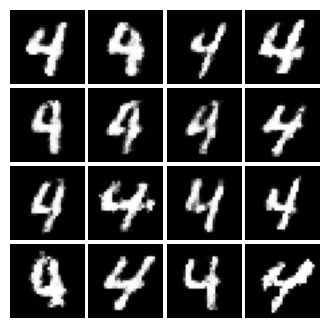

In [ ]:
# plot generated digit

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
  ax = plt.subplot(gs[i])
  plt.axis('off')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_aspect('equal')
  plt.imshow(sample.reshape(28, 28), cmap='Greys_r')